<a href="https://colab.research.google.com/github/DmitryKutsev/ml_hw/blob/master/hw7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#https://github.com/mannefedov/hse_ml_m1/blob/master/7_cnn/cnn.ipynb
#7
# https://docs.google.com/forms/d/e/1FAIpQLSee0e7Tis3EoPnxGqyb_vHuR-u9Dz2M85ajMd-m9uNX1bsepQ/viewform

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!unzip '/content/drive/My Drive/data.zip'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Archive:  /content/drive/My Drive/data.zip
  inflating: avito_data.csv          
  inflating: quora.csv               
  inflating: __MACOSX/._quora.csv    


In [3]:
!pip install pandas scikit-learn gensim matplotlib

In [0]:
import tensorflow as tf

In [0]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    string = ''.join(tokens)
    symbols = [i for i in string if i != " "]
    return symbols

In [0]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
quora = pd.read_csv('quora.csv')

In [9]:
quora

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


In [0]:
vocab = Counter()

for text in quora.question_text:
    vocab.update(preprocess(text))

In [68]:
vocab.most_common(5)

[('e', 8363288),
 ('a', 6388387),
 ('t', 6225943),
 ('o', 6026222),
 ('i', 5826579)]

In [0]:
filtered_vocab = set()

# for word in vocab:
#     if vocab[word] > 5:
#         filtered_vocab.add(word)

In [0]:
word2id = {'UNK':1, 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [0]:
id2word = {i:word for word, i in word2id.items()}

In [0]:
X = []

for text in quora.question_text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [0]:
MAX_LEN = max(len(x) for x in X)
MEAN_LEN = np.median([len(x) for x in X])

In [0]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [0]:
y = quora.target.values

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [0]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=10)(inputs, )

# все остальное точно такое же
# возвращает сверточный слой тоже последовательность векторов слегка измененной или такой же длины
conv1 = tf.keras.layers.Conv1D(kernel_size=10, filters=32)(embeddings)

# выход со сверточного слоя также можно просто конкатенировать
concat = tf.keras.layers.Flatten()(conv1)
dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [79]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1500,
         epochs=5)

Epoch 1/5
828/828 [==============================] - 1102s 1s/step - loss: 0.2190 - f1: 2.3681e-05 - val_loss: 0.2188 - val_f1: 0.0000e+00
Epoch 2/5
828/828 [==============================] - 1094s 1s/step - loss: 0.2190 - f1: 5.7584e-05 - val_loss: 0.2185 - val_f1: 0.0000e+00
Epoch 3/5
828/828 [==============================] - 1093s 1s/step - loss: 0.2187 - f1: 2.3681e-05 - val_loss: 0.2183 - val_f1: 0.0000e+00
Epoch 4/5
828/828 [==============================] - 1109s 1s/step - loss: 0.2186 - f1: 4.7141e-05 - val_loss: 0.2191 - val_f1: 0.0000e+00
Epoch 5/5
828/828 [==============================] - 1117s 1s/step - loss: 0.2187 - f1: 4.9612e-05 - val_loss: 0.2189 - val_f1: 0.0000e+00


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


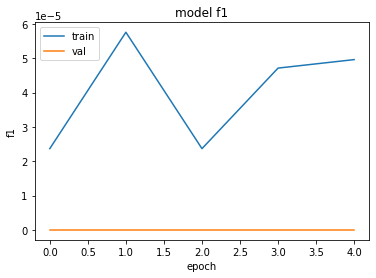

In [80]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()